In [9]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

In [10]:
root_dir = 'kill_me_images/kill_me_baby_datasets/'

class_list = sorted(os.listdir(path=root_dir))
print("クラスリスト", class_list)

クラスリスト ['agiri', 'botsu', 'others', 'sonya', 'yasuna', 'yasuna&agiri', 'yasuna&sonya']


In [14]:
def load_imgs(root_dir):    

    print(class_list)
    num_class = len(class_list)
    img_paths = []
    labels = []
    images = []
    for cl_name in class_list:
        img_names = os.listdir(os.path.join(root_dir, cl_name))
        for img_name in img_names:
            img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
            hot_cl_name = get_class_one_hot(cl_name, class_list)
            labels.append(hot_cl_name)

#     print(img_paths)
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    images = np.array(images)

    return np.array(images), np.array(labels), class_list

In [15]:
def get_class_one_hot(class_str, class_list):
    label = class_list.index(class_str)
    label_hot = tf.one_hot(label, len(class_list))
    
    return label_hot

In [16]:
orig_image, orig_label, class_list = load_imgs(root_dir='kill_me_images/kill_me_baby_datasets/')

['agiri', 'botsu', 'others', 'sonya', 'yasuna', 'yasuna&agiri', 'yasuna&sonya']


In [17]:
# vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', classes=7, input_shape=(128, 128, 3))
# vgg16.trainable = False

# inputs = tf.keras.Input(shape=vgg16.output.shape[1:])
# x = tf.keras.layers.Flatten()(inputs)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# logits = tf.keras.layers.Dense(len(class_list), name='logits')(x)
# out = tf.keras.layers.Activation('softmax')(logits)

# top_model = tf.keras.Model(inputs=inputs, outputs=out)

# model = tf.keras.Model(inputs=vgg16.input, outputs=top_model(vgg16.output))


# # 最後の畳み込み層の前までの重みの更新はしない。
# # 15層目が最後の畳み込み層の開始位置
# for layer in model.layers[:15]:
#     layer.trainable = False

# model.summary()

In [18]:
# print(model.layers[15].name)

In [19]:
# batch_size = 32

# # 学習方法を設定する
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# tb_cb = tf.keras.callbacks.TensorBoard(log_dir="log_dir")
# ckps = [tb_cb]

# # 学習用データを用意する
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)
# train_generator = train_datagen.flow_from_directory('kill_me_images/kill_me_baby_datasets/', classes=class_list, target_size=(128, 128), batch_size=batch_size, class_mode='categorical')

# # 学習開始！
# model.fit_generator(train_generator, steps_per_epoch=train_generator.samples//batch_size, epochs=100, callbacks=ckps)
# model.save("models/killme_vgg16.h5")

# sess = tf.keras.backend.get_session()
# saver = tf.train.Saver()
# saver.save(sess, "models/killme_vgg16.ckpt")

# # 作成したFine-tuning VGG16モデルをロード
model = tf.keras.models.load_model('models/killme_vgg16.h5')


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## 普通の画像(Adversarial Example)ではない画像の結果

推論結果のインデックス： 6
推論結果のクラス yasuna&sonya


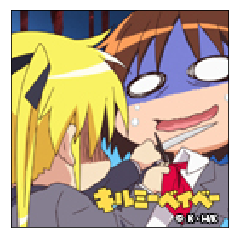

In [21]:
ref_idx = 650

result_num = np.argmax(model.predict(np.expand_dims(orig_image[ref_idx]/255.0, axis=0)))

print("推論結果のインデックス：", result_num)
print("推論結果のクラス", class_list[result_num])
plt.imshow(np.squeeze(orig_image[ref_idx]/255.0))
plt.tick_params(labelbottom=False, labelleft=False, color='white')

## Fine-tunineのノードへアクセスする
TensorBoardを見ると参照先の名前がわかる

In [22]:
# tf.summary.FileWriter('log_dir', model.graph)

In [23]:
# !tensorboard --logdir='log_dir/'

In [24]:
y_pred = model.graph.get_tensor_by_name('model_1/activation_1/Softmax:0')
y_logits = model.graph.get_tensor_by_name('model_1/logits/BiasAdd:0')
input_img = model.graph.get_tensor_by_name('input_1:0')

In [25]:
with model.graph.as_default():
    pl_cls_target = tf.placeholder(dtype=tf.int32, name='pl_cls_target')
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target], name='sparse_loss')
    gradient = tf.gradients(loss, input_img, name='adv_gradient')
    
sess = tf.keras.backend.get_session()
saver = tf.train.Saver()
saver.save(sess, "models/killme_vgg16.ckpt")

'models/killme_vgg16.ckpt'

In [26]:
# tf.summary.FileWriter('log_dir', model.graph)

In [27]:
# !tensorboard --logdir='log_dir'

In [28]:
y_pred = 'model_1/activation_1/Softmax:0'
y_logits = 'model_1/logits/BiasAdd:0'
input_img = 'input_1:0'

In [29]:
# with tf.Session() as sess:
#     saver.restore(sess, 'models/killme_vgg16.ckpt')
#     tf.summary.FileWriter('log_dir', sess.graph)   
    

In [30]:
# with tf.Session() as sess:
#     saver.restore(sess, "models/killme_vgg16.ckpt")
#     pred = sess.run(y_pred, feed_dict={input_img: np.expand_dims(orig_image[ref_idx]/255., axis=0)})
#     pred_idx = np.argmax(sess.run(y_pred, feed_dict={input_img: np.expand_dims(orig_image[ref_idx]/255., axis=0)}))
#     logits = sess.run(y_logits, feed_dict={input_img: np.expand_dims(orig_image[ref_idx]/255., axis=0)})

# print(pred)
# print(pred_idx)
# print(logits)

## Adversarial Examplesを作っていく

In [31]:
def find_adversary_noise(image_path, cls_tar, noise_limit=3.0, required_score=0.99, iterations=100, top_k=5):
    
    image = np.array(Image.open(image_path))
    image.flags.writeable = True
    image = np.expand_dims(image, axis=0)
    
    with tf.Session() as sess:
        
        saver.restore(sess, "models/killme_vgg16.ckpt")
        pred = sess.run(y_pred, feed_dict={input_img: image/255.})
        pred = np.squeeze(pred)
        
        # 予測クラスの番号
        cls_source = np.argmax(pred)
        # 予測クラス名
        cls_name_source = class_list[cls_source]
        # ターゲットのクラス名
        cls_name_tar = class_list[cls_tar]        
        # 予測確率
        prob_source = np.max(pred)
        
        # Adversarial Examplesで加えるノイズ
        noise = 0
        
        for i in range(iterations):
            print("イテレーション：", i)
        
            adv_img = image + noise
            adv_img = np.clip(a=adv_img, a_min=0.0, a_max=255.0)
            
            pred, grad = sess.run([y_pred, gradient], feed_dict={input_img: adv_img/255.0, pl_cls_target: cls_tar})
            pred = np.squeeze(pred)            
            
            score_source = pred[cls_source]
            score_target = pred[cls_tar]
            
            grad = np.array(grad).squeeze()
            
            grad_absmax = np.abs(grad).max()
            
            if grad_absmax < 1e-10:
                grad_absmax = 1e-10
            
            step_size = 7/ grad_absmax
            
            msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_source, cls_source, cls_name_source))

            # Print the score etc. for the target-class.
            msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_target, cls_tar, cls_name_tar))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Newline.
            print()
            
            if score_target < required_score:
                noise -= step_size * grad
                
                noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)
            else:
                break
        return image.squeeze(), adv_img.squeeze(), noise, cls_name_source, cls_name_tar, score_source, prob_source, score_target, pred

In [32]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    
    x_norm = (x-x_min) / (x_max - x_min)
    
    return x_norm

In [33]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target, probs, top_k=5):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # 日本語フォントを導入
    fontprop = matplotlib.font_manager.FontProperties(fname="/usr/share/fonts/truetype/fonts-japanese-gothic.ttf")
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 4, figsize=(20,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)

    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)
    
    ax = axes.flat[3]
    
    top_k_idx = np.argsort(probs)[:-top_k-1:-1]
    adv_x = range(top_k)
    adv_y = probs[top_k_idx]
    label = [class_list[i] for i in top_k_idx]
    
    ax.bar(adv_x, adv_y, tick_label=label, width=0.5)
    ax.set_xlabel(u'Adversarial Examplesの確率トップ{}'.format(top_k), fontdict = {"fontproperties": fontprop, "fontsize": 15})
    
    # Remove ticks from all the plots.
    for ax in axes.flat[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    
    plt.savefig('kill_me_images/gen_adv/{}_to_{}.png'.format(name_source, name_target))
    
    plt.show()

In [34]:
def adversarial_example(img_path, cls_tar, noise_limit, required_score, iterations):
    
    image, adv_img, noise, cls_name_source, cls_name_tar, score_source, prob_source, score_target, probs\
    = find_adversary_noise(image_path=img_path, cls_tar=cls_tar, noise_limit=noise_limit, required_score=required_score, iterations=iterations)
    
    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=adv_img,
                name_source=cls_name_source, name_target=cls_name_tar,
                score_source=score_source,
                score_source_org=prob_source,
                score_target=score_target,
                probs=probs)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))
    
    return image, adv_img, noise

sonya
INFO:tensorflow:Restoring parameters from models/killme_vgg16.ckpt
イテレーション： 0
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -2.623274, max:  2.897395, stepsize:      2.42

イテレーション： 1
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -3.159919, max:  2.715192, stepsize:      2.22

イテレーション： 2
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.780500, max:  2.453687, stepsize:      2.85

イテレーション： 3
Source score:  27.53%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -0.911747, max:  1.113490, stepsize:      6.29

イテレーション： 4
Source score:  97.15%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient 

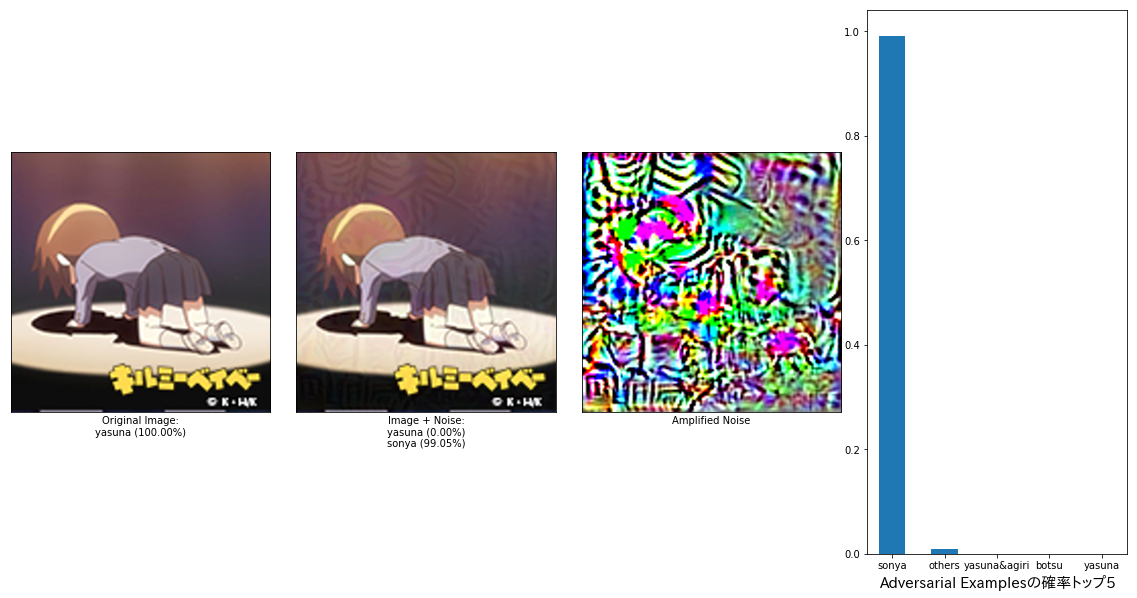

Noise min: -5.000, max: 5.000, mean: 0.046, std: 3.748


In [35]:
img_path = 'kill_me_images/kill_me_baby_datasets/yasuna/01_034.png'
cls_tar = 3

print(class_list[cls_tar])
image_source, adv_img, noise = adversarial_example(img_path=img_path, cls_tar=cls_tar, noise_limit=5.0, required_score=0.99, iterations=1000)

In [36]:
model = tf.keras.models.load_model('models/killme_vgg16.h5')

source_result = class_list[np.argmax(model.predict(np.expand_dims(image_source/255.0, axis=0)))]
adv_result = class_list[np.argmax(model.predict(np.expand_dims(adv_img/255.0, axis=0)))]

print('オリジナル画像の結果=', source_result, '  |Adversarial Exampleの結果=', adv_result)

オリジナル画像の結果= yasuna   |Adversarial Exampleの結果= sonya


In [46]:
dif_image = np.array(Image.open('kill_me_images/kill_me_baby_datasets/agiri/02_050.png'))
dif_image.flags.writeable = True
dif_adv_image = dif_image + noise

dif_adv_image = np.clip(a=dif_adv_image, a_min=0.0, a_max=255.0)

dif_adv_result = model.predict(np.expand_dims(dif_adv_image/255.0, axis=0)).squeeze()
dif_adv_num = np.argmax(dif_adv_result)
dif_adv_cls = class_list[dif_adv_num]

print("オリジナル画像の分類結果")
print(class_list[np.argmax(model.predict(np.expand_dims(dif_image/255.0, axis=0)))])

print('\nAdversarial Examplesの分類結果')
print(dif_adv_cls)

print('\nAdversarial Examplesの確率分布')
print(dif_adv_result)

# dif_adv_image = dif_adv_image.squeeze()
# cv2.imwrite('kill_me_images/adv_img/dif_img.png', dif_adv_image)

# plt.imshow(dif_adv_image.squeeze()/255.0)
plt.imsave('kill_me_images/gen_adv/dif_img.png', dif_adv_image.squeeze()/255.0)

オリジナル画像の分類結果
agiri

Adversarial Examplesの分類結果
agiri

Adversarial Examplesの確率分布
[1.0000000e+00 0.0000000e+00 3.8179437e-34 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
